# ToDO:
- Hook, dass die NB Outputs im pre-commit gecleared werden

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from google.cloud import bigquery as bq

# Import Data

In [6]:
def get_bq_table(table_id, file_path=None, project_id: str = "brain-flash-dev", dataset_id: str = "dagster_common"):
    client = bq.Client(project=project_id)
    table_ref = f"{project_id}.{dataset_id}.{table_id}"

    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()

    if file_path is not None:
        df.to_csv(file_path, index=False)
        print(f"DataFrame saved to {file_path}")
    
    return df

In [7]:
get_bq_table("CN_data_to_fetch", file_path='data/twins_100.csv')

DataFrame saved to data/twins_100.csv


,TEST_ITEM_COMMUNICATIONKEY,NA_QUOTA,TWIN_ITEM_COMMUNICATIONKEY,CALENDAR_DATE,ANSPRACHE,ANSPRACHE_MARKETING_IMPUTED,FRACTION_SOLDOUT,TWIN_COUNT,FIRST_ANSPRACHE_DATE,LAST_ANSPRACHE_DATE,FIRST_SOLDOUT_DATE,FIRST_SOLDOUT20_DATE,NA_COUNT,TEST_PERIOD,OBS_PERIOD
0,716679764,0.0,551971034,2018-02-10,1,1,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,671
1,716679764,0.0,551971034,2018-02-11,2,2,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,671
2,716679764,0.0,551971034,2018-02-12,0,0,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,671
3,716679764,0.0,551971034,2018-02-13,0,0,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,671
4,716679764,0.0,551971034,2018-02-14,1,1,0.000000,9,2019-02-08,2019-12-12,2019-09-03,2019-09-06,0,307,671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299991,1720805025,0.0,1720805025,2024-07-07,0,0,0.571429,7,2023-07-14,2025-01-08,2023-10-21,2023-10-21,0,363,727
299992,1720805025,0.0,1720805025,2024-07-08,0,0,0.571429,7,2023-07-14,2025-01-08,2023-10-21,2023-10-21,0,363,727
299993,1720805025,0.0,1720805025,2024-07-09,0,0,0.571429,7,2023-07-14,2025-01-08,2023-10-21,2023-10-21,0,363,727
299994,1720805025,0.0,1720805025,2024-07-10,2,2,0.636000,7,2023-07-14,2025-01-08,2023-10-21,2023-10-21,0,363,727


In [10]:
df = pd.read_csv('data/twins_100.csv')

# Local Block Bootstrap (LBB)

In [39]:
np.random.randint(0, 1)

0

In [27]:
class Sampling:
    def __init__(self, data: pd.DataFrame, num_samples: int, seed: int = 161):
        self.data = data
        self.num_samples = num_samples
        self.seed = seed
        np.random.seed(self.seed)

    def prepare_data(self, num_twins: int, key: int) -> pd.DataFrame:

        #warning, when wanted num_twins higher than twin count

        if num_twins == 0:
            #case: test item
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)
        else:
            #case: twin items
            df = self.data.loc[
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] == key) & 
                (self.data["TEST_ITEM_COMMUNICATIONKEY"] != self.data["TWIN_ITEM_COMMUNICATIONKEY"]),
                ["CALENDAR_DATE", "TWIN_ITEM_COMMUNICATIONKEY", "ANSPRACHE"]
            ].reset_index(drop=True)

            # reduce to wanted number of twin items
            df = df.iloc[:, :5]

        df = df.pivot(index="CALENDAR_DATE", columns="TWIN_ITEM_COMMUNICATIONKEY", values="ANSPRACHE")
        print(df.head())
        return df

    def iid_bootstrap(self, key: int, num_twins: int = 0) -> pd.Series:
        data = self.prepare_data(num_twins, key)

        M, N = data.shape

        bootstrap_sums = []
        for _ in range(self.num_samples):
            samples = []
            for _ in range(M):
                samples.extend(df.iloc[np.random.randint(0, M), np.random.randint(0, N)])
        bootstrap_sums.append(sum(samples))
    
        return pd.Series(bootstrap_sums, name="Bootstrap_Sums")

    def local_block_bootstrap(self, key: int, num_twins: int) -> pd.Series:
        data = self.prepare_data(num_twins, key)
        # Implement block bootstrap logic here


In [28]:
sampeler = Sampling(df, 100)

In [ ]:
sampeler.iid_bootstrap(1, 0)

In [ ]:
#brauche ich eine Solution-Klasse oder schreibe ich die einfach immer in eine Datei?

In [ ]:
class Evaluation():
    def __init (self):
        pass
    #MSE evaluation
    #Wasserstein evaluation

In [11]:
#lbb(mit overlapping und nicht overlapping blocks), lb, 

def lbb(test_key: int = 1063668113, B: float = 0.1, df: pd.DataFrame = df, b: int = 7, samples: int = 5000):
    df_slice = df.query("TEST_ITEM_COMMUNICATIONKEY == @test_key", engine='python')
    twins = df_slice.query("TEST_ITEM_COMMUNICATIONKEY != TWIN_ITEM_COMMUNICATIONKEY", engine='python')
    test = df_slice.query("TEST_ITEM_COMMUNICATIONKEY == TWIN_ITEM_COMMUNICATIONKEY", engine='python')

    #conditions on input...
    test_data = test["ANSPRACHE"]

    n = len(test)
    M = range(int(np.ceil(n/b)))

    bootstrap_sample = []
    #iterate number of blocks
    for m in M:
        
        #define valid neighborhood range
        J_1m = max(1, m*b-n*B)
        J_2m = min(n-b+1, m*b+n*B)

        #draw block starting index
        I_m = np.random.uniform(J_1m, J_2m)

        #draw block from sample series
        sampled_block = test_data.iloc[int(I_m-1):int(I_m+b)] #consider 0 indexing by -1
        bootstrap_sample.extend(sampled_block)

    
    #ggf shorten time series
    return test_data, bootstrap_sample

In [26]:
og, test = lbb()

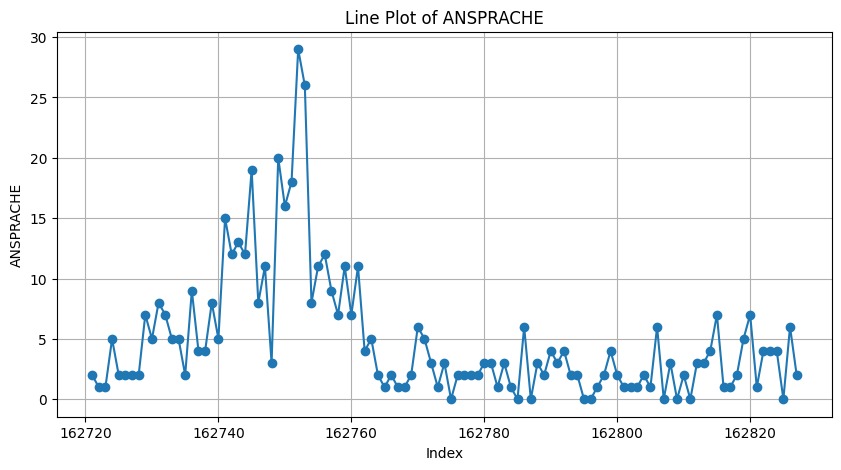

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(og, marker='o')  # Plot the list directly
plt.title('Line Plot of ANSPRACHE')
plt.xlabel('Index')
plt.ylabel('ANSPRACHE')
plt.grid()
plt.show()

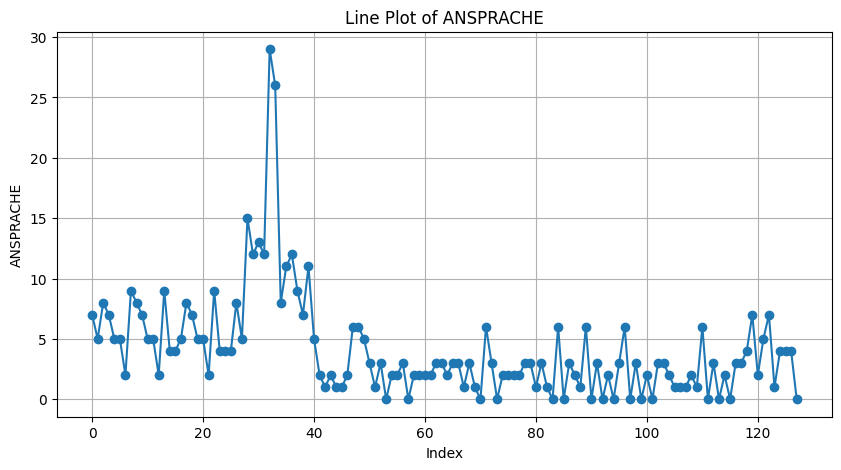

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(test, marker='o')  # Plot the list directly
plt.title('Line Plot of ANSPRACHE')
plt.xlabel('Index')
plt.ylabel('ANSPRACHE')
plt.grid()
plt.show()

## Time dependent Bootstrap sampling

In [3]:
sampler = Sampling("0123456789", synthetic=False)

In [4]:
for scen in ["default", "medium_medium_deal", "medium_medium_DDM", "medium_medium_DDW"]:
    distr = sampler.bootstrap_joint_distribution(scenario = scen)
sampler.save_results()

# Normality test
- tune number of iteration until distribution is normal

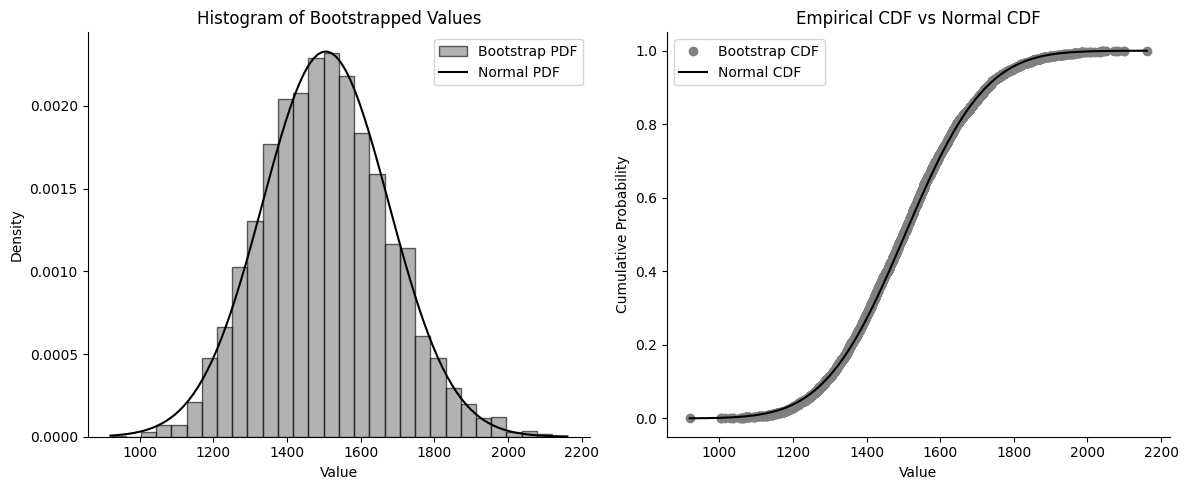

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
ax1.hist(distr, bins=30, density=True, alpha=0.6, color='grey', edgecolor='black', label='Bootstrap PDF')
ax1.set_title('Histogram of Bootstrapped Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')

# Remove top and right spines for the histogram
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Calculate the normal PDF
x = np.linspace(min(distr), max(distr), 100)
normal_pdf = stats.norm.pdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal PDF
ax1.plot(x, normal_pdf, label='Normal PDF', color='black', linestyle='-')

# Plot the empirical CDF
data_sorted = np.sort(distr)
# Calculate the ECDF values
ecdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
ax2.plot(data_sorted, ecdf, marker='o', linestyle='none', color='grey', label='Bootstrap CDF')

# Remove top and right spines for the CDF
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Calculate the normal CDF
normal_cdf = stats.norm.cdf(x, loc=np.mean(distr), scale=np.sqrt(np.var(distr, ddof = 1)))

# Plot the normal CDF
ax2.plot(x, normal_cdf, label='Normal CDF', color='black', linestyle='-')

ax2.set_title('Empirical CDF vs Normal CDF')
ax2.set_xlabel('Value')
ax2.set_ylabel('Cumulative Probability')

# Add legends
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.savefig('plots/bootstrap_joint_distribution.svg')
plt.show()


In [6]:
#define alpha level
alpha = 0.05

In [7]:
_, p_value = stats.normaltest(distr)
print(p_value)

8.546987677552962e-09


In [8]:
_, p_value = stats.shapiro(distr)
print(p_value)

4.5215951590459825e-08
